# Synthetic Mutual Information Datasets

In [2]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])
pysim_root = "/home/emmanuel/code/pysim"
# append to path
sys.path.append(str(root))
sys.path.append(str(pysim_root))

import numpy as np

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
import corner

sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2
%load_ext lab_black

## Mutual Information

### Estimators

In [3]:
# !pip install "git+https://github.com/gregversteeg/NPEET.git"
# !pip install mutual-info

In [32]:
from mutual_info.mutual_info import mutual_information as mi_mutual_info
from npeet.entropy_estimators import mi as npeet_mutual_info

In [33]:
from pysim.information.gaussian import gauss_entropy_multi
from pysim.information.knn import knn_entropy, knn_entropy_npeet
from pysim.information.mutual import multivariate_mutual_information
import time


def get_mi_estimators(X, Y):

    t0 = time.time()
    res = multivariate_mutual_information(X=X.copy(), Y=Y.copy(), f=gauss_entropy_multi)
    print(f"Gaussian: {res['mi']:.4f} | Time: {time.time()-t0:.4f} secs")

    t0 = time.time()
    res = mi_mutual_info((X.copy(), Y.copy()), k=10, transform=None)
    print(f"KNN (Neighbours):  {res:.4f} | Time: {time.time()-t0:.4f} secs")

    t0 = time.time()
    res = npeet_mutual_info(x=X.copy(), y=Y.copy(), k=10, base=np.e,)
    print(f"KNN (epsilon):  {res:.4f} | Time: {time.time()-t0:.4f} secs")

## Toy Data

In [34]:
n_samples = 50_000
n_features = 5
seed = 123

### Gaussian

**Implementation Notes**:

1. We randomly generate a positive semi-definite $D \times D$ matrix. This acts as our covariance matrix $\boldsymbol{\Sigma}$.

2. We use a mean, $\boldsymbol{\mu}$ of $\mathbf{0}$.

3. We generate an upper limit of 5e5 data points and then random subset the requested number.

In [35]:
from pysim.data.information.gaussian import generate_gaussian_mi_data
from pysim.data.information.studentt import generate_studentt_mi_data

from functools import partial

In [36]:
# create seed (trial number)
res_tuple = generate_gaussian_mi_data(
    n_samples=n_samples, n_features=n_features, seed=seed, n_base_samples=500_000,
)

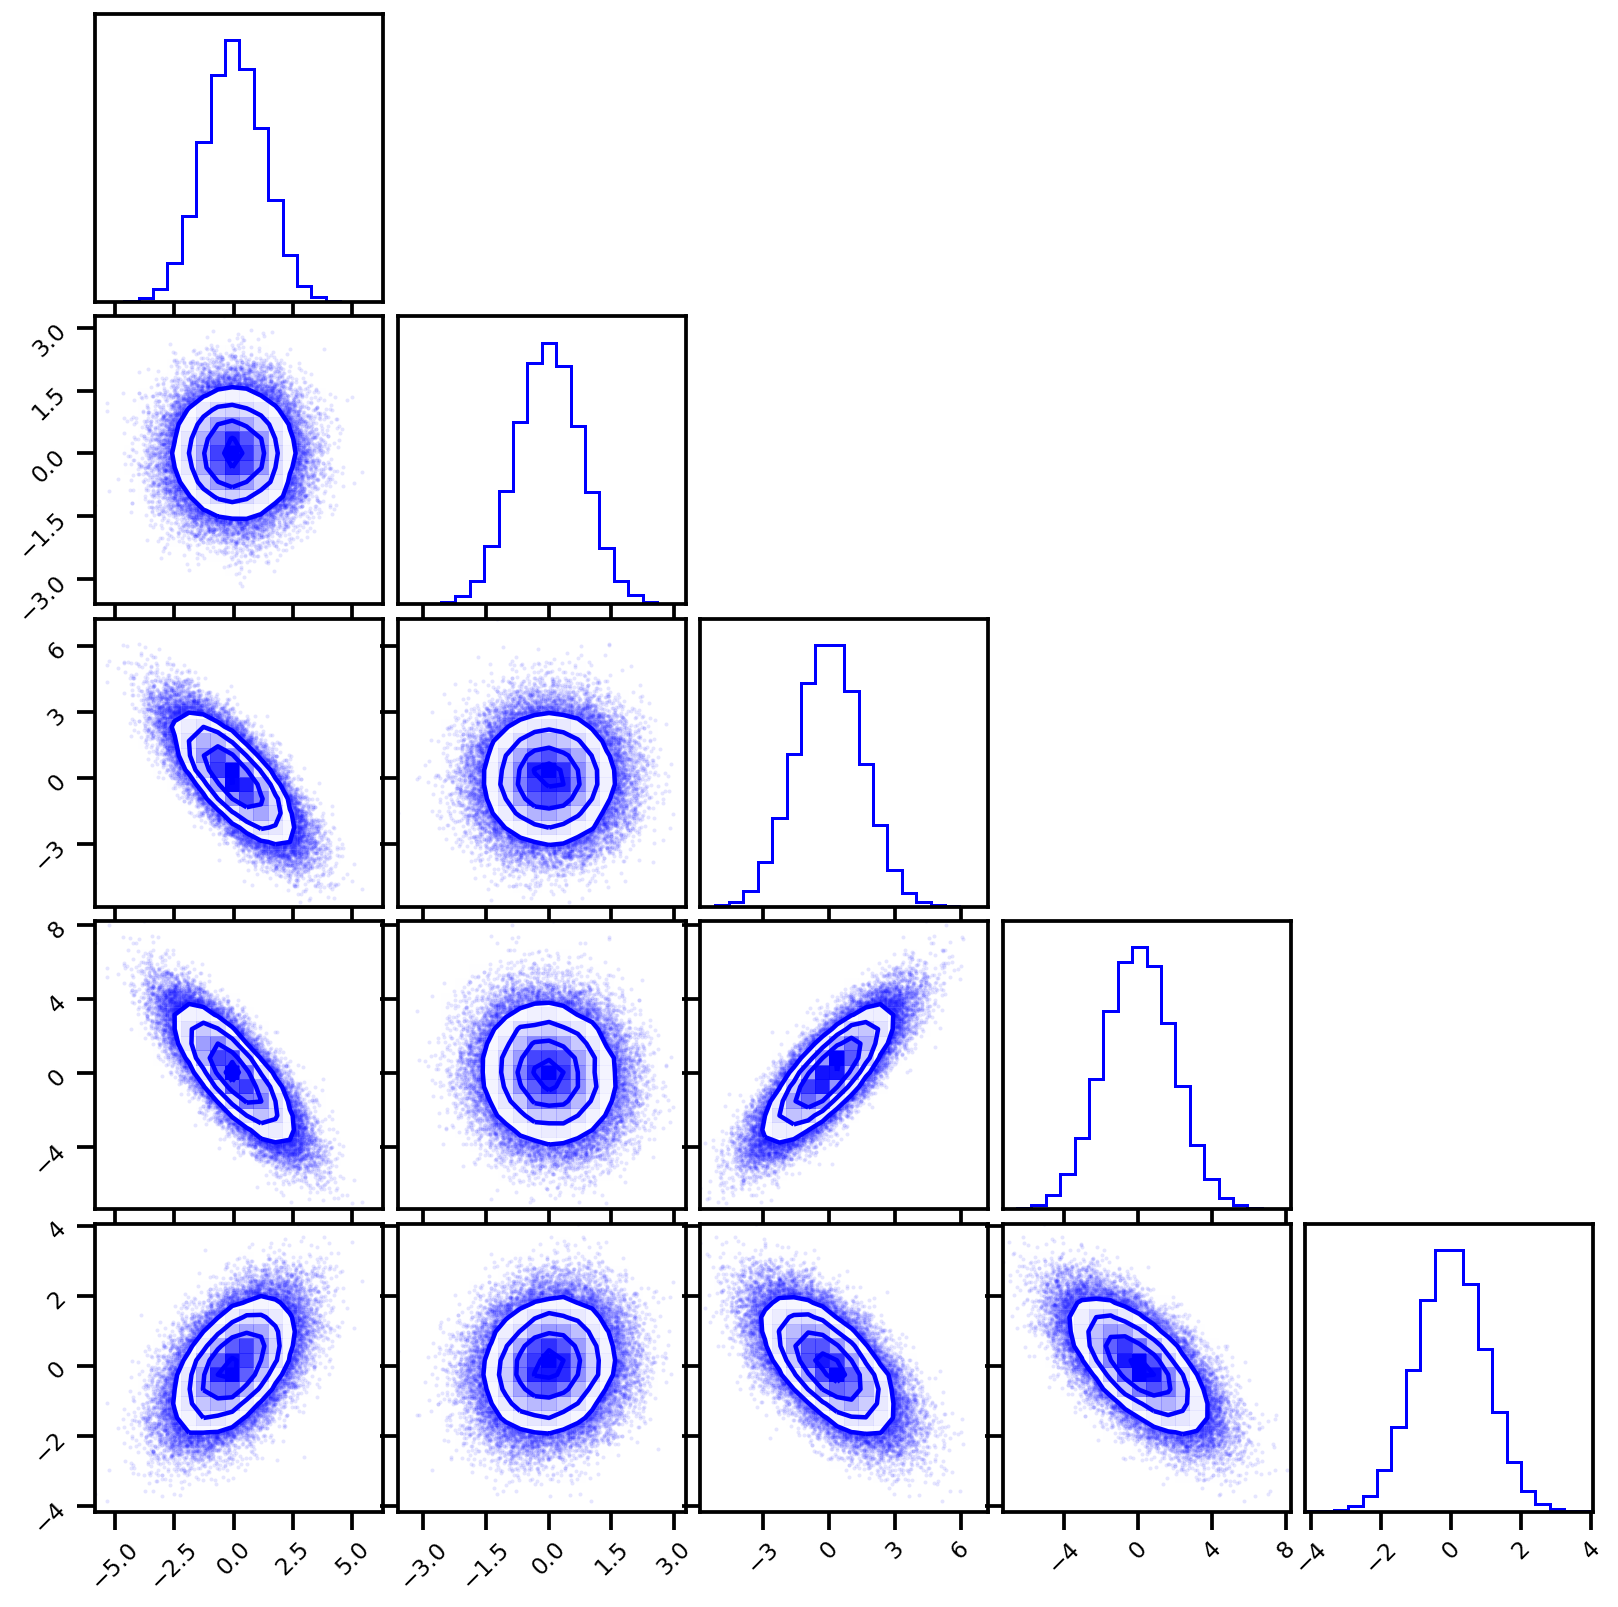

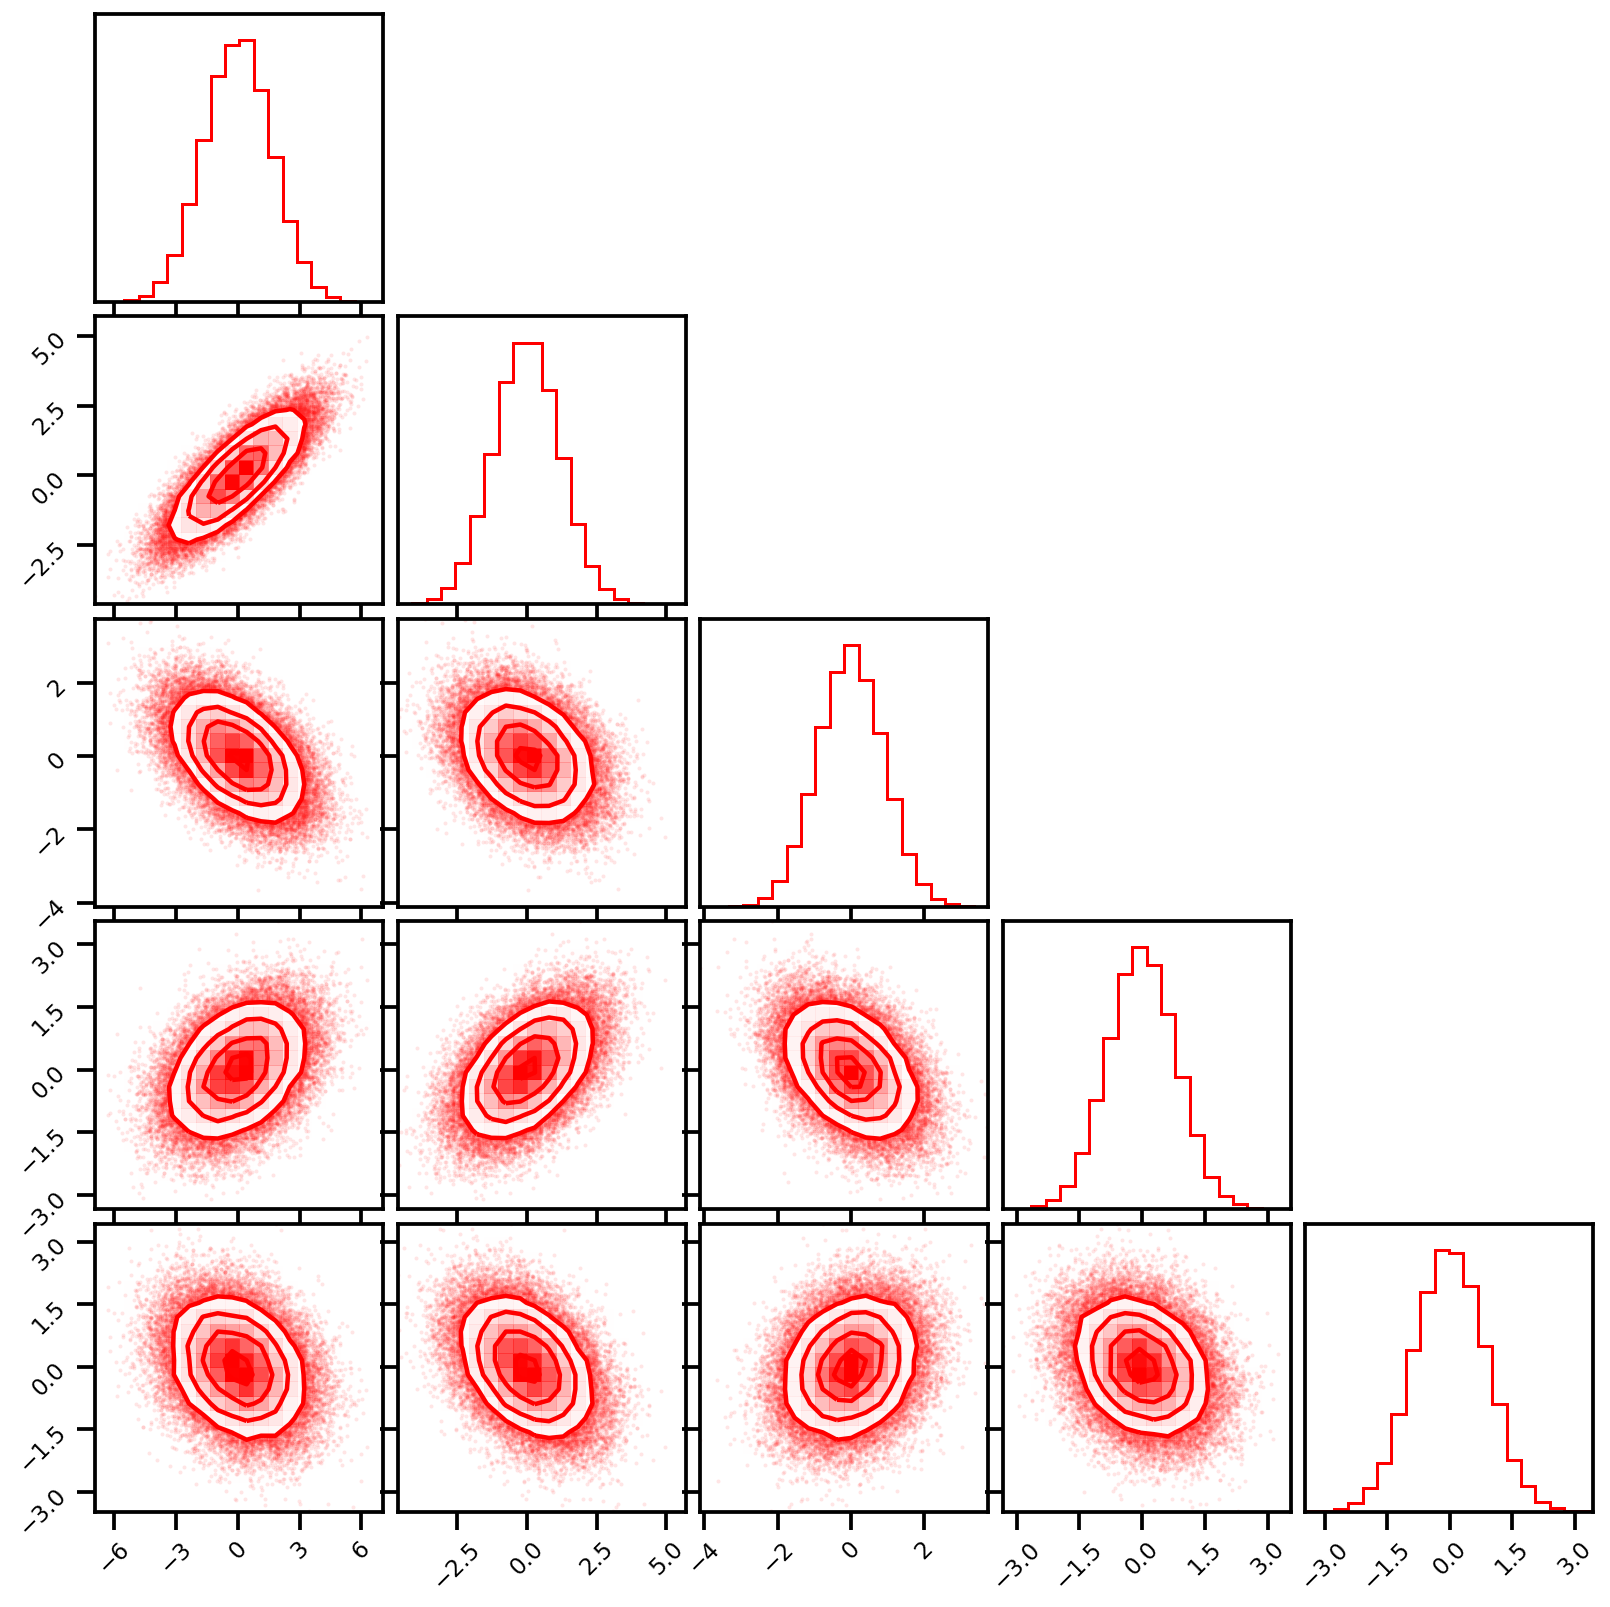

In [37]:
fig = corner.corner(res_tuple.X[:, :10], color="blue")
fig = corner.corner(res_tuple.Y[:, :10], color="red")

#### Mutual Information

We will make use of the standard summation formula:

$$
I(\mathbf{X,Y}) = H(\mathbf{X}) + H(\mathbf{Y}) - H(\mathbf{X,Y})
$$

which uses the standard entropy formula:

$$
\begin{aligned}
H(\mathbf{X}) &= \frac{D}{2} + \frac{D}{2}\log (2\pi)+ \frac{1}{2}\log \left|\boldsymbol{\Sigma}_{\mathbf{xx}} \right| \\
H(\mathbf{Y}) &= \frac{D}{2} + \frac{D}{2}\log (2\pi)+ \frac{1}{2}\log \left|\boldsymbol{\Sigma}_{\mathbf{yy}} \right| \\
H(\mathbf{X,Y}) &= \frac{D_x + D_y}{2} + \frac{D_x + D_y}{2}\log (2\pi)+ \frac{1}{2}\log \left|\boldsymbol{\Sigma}_{\mathbf{xy}} \right| \\
\end{aligned}
$$

where:

* $D$ - number of features
* $\left|\cdot \right|$ - absolute determinant
* $\boldsymbol{\Sigma}_{\mathbf{xx}} \in \mathbb{R}^{D \times D}$ - covariance matrix

**Note**: This entropy measure has the units `nats`.

In [38]:
print(f"True Value: {res_tuple.MI:.4f}")

True Value: 1.4134


In [39]:
get_mi_estimators(res_tuple.X.copy(), res_tuple.Y.copy())

Gaussian: 1.4256 | Time: 0.0241 secs
KNN (Neighbours):  1.1637 | Time: 12.1614 secs
KNN (epsilon):  1.2608 | Time: 9.9496 secs


### T-Student

In [24]:
# create seed (trial number)
df = 5.0
res_tuple = generate_studentt_mi_data(
    n_samples=n_samples,
    n_features=n_features,
    df=df,
    seed=seed,
    n_base_samples=500_000,
)

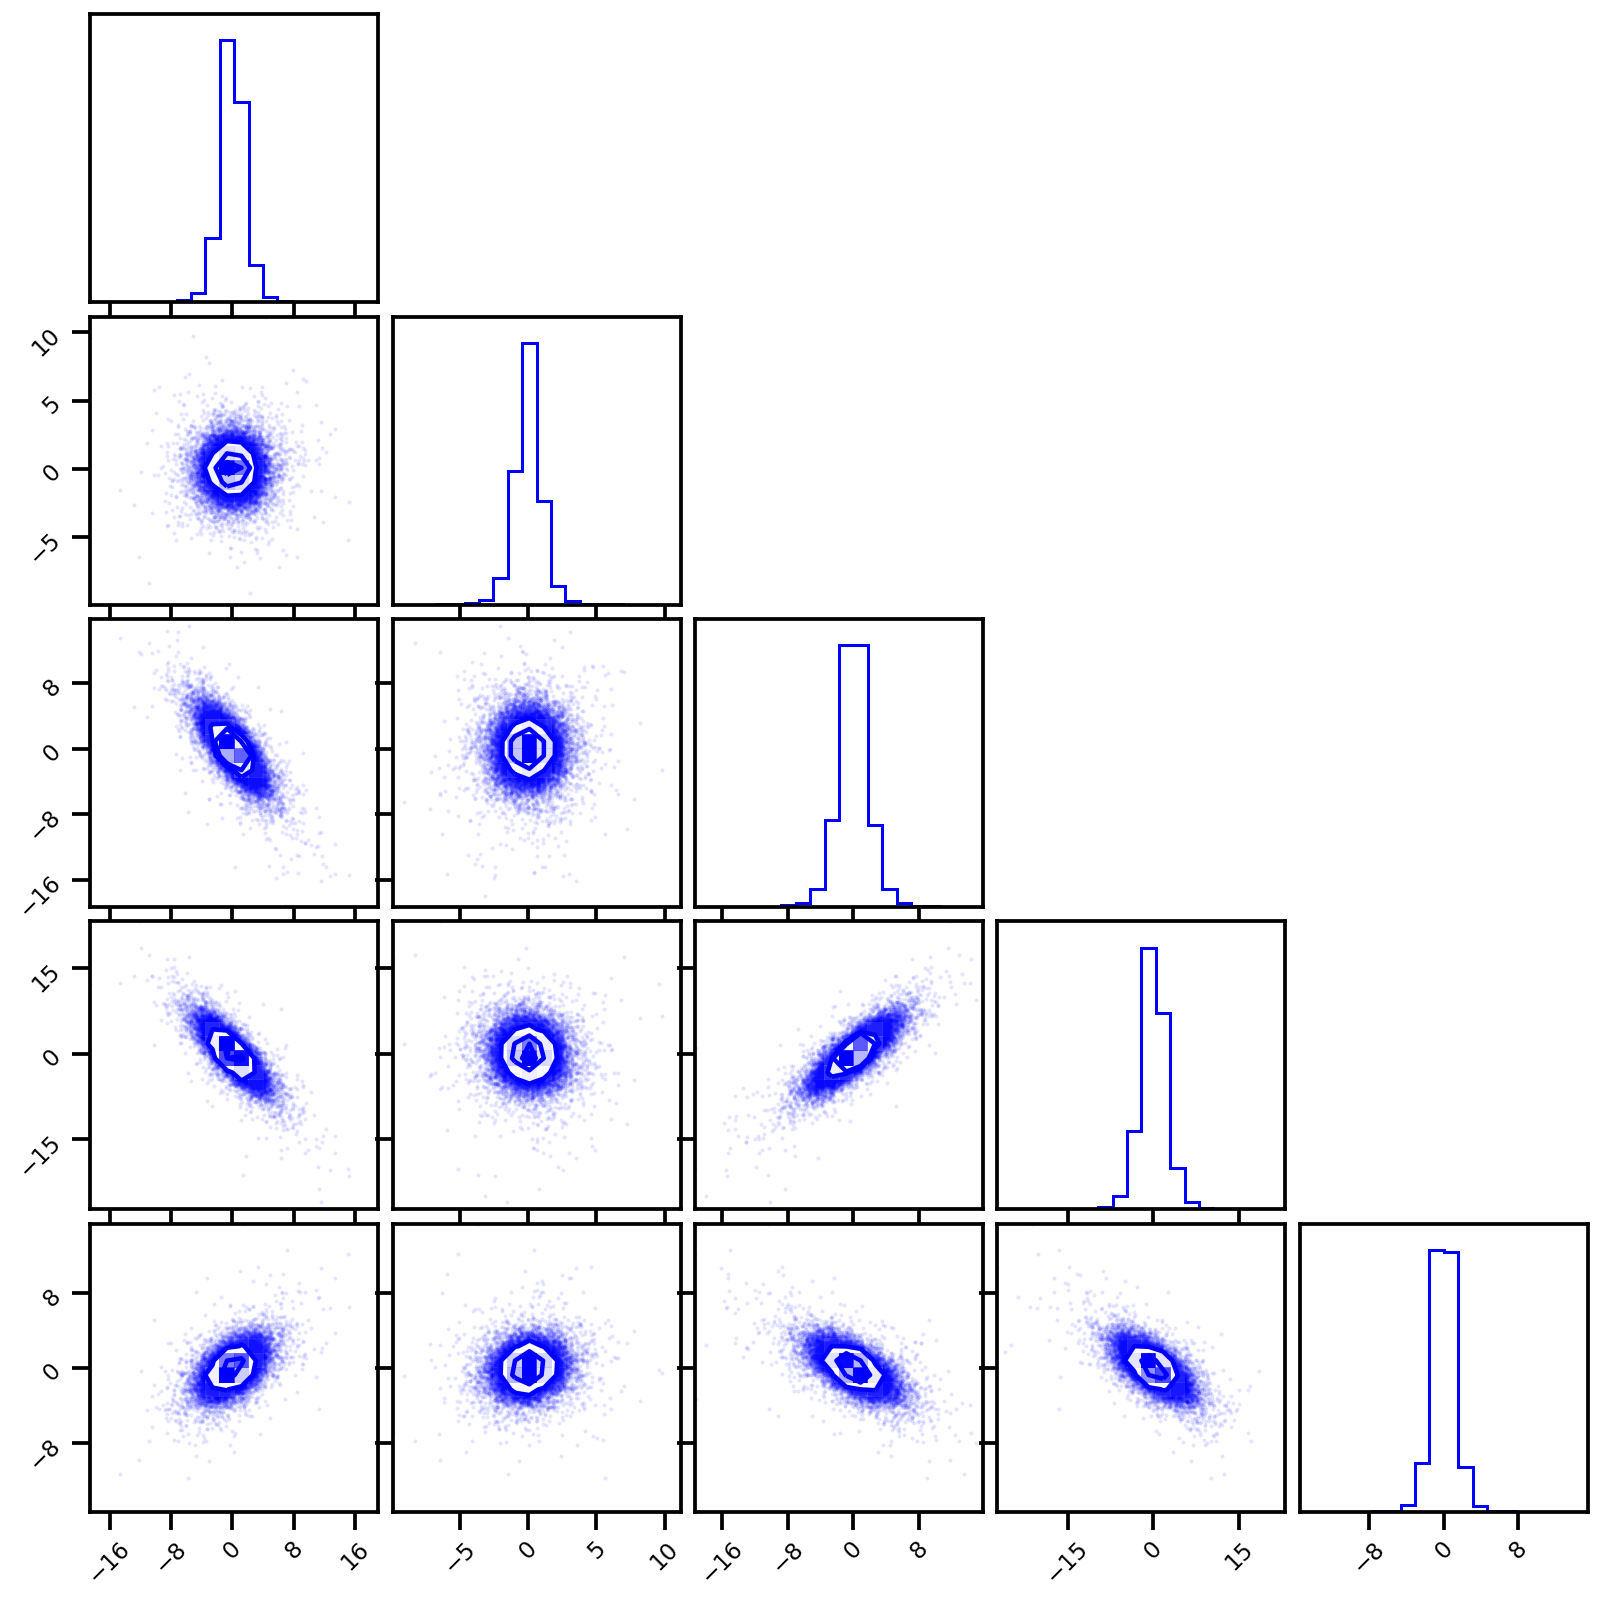

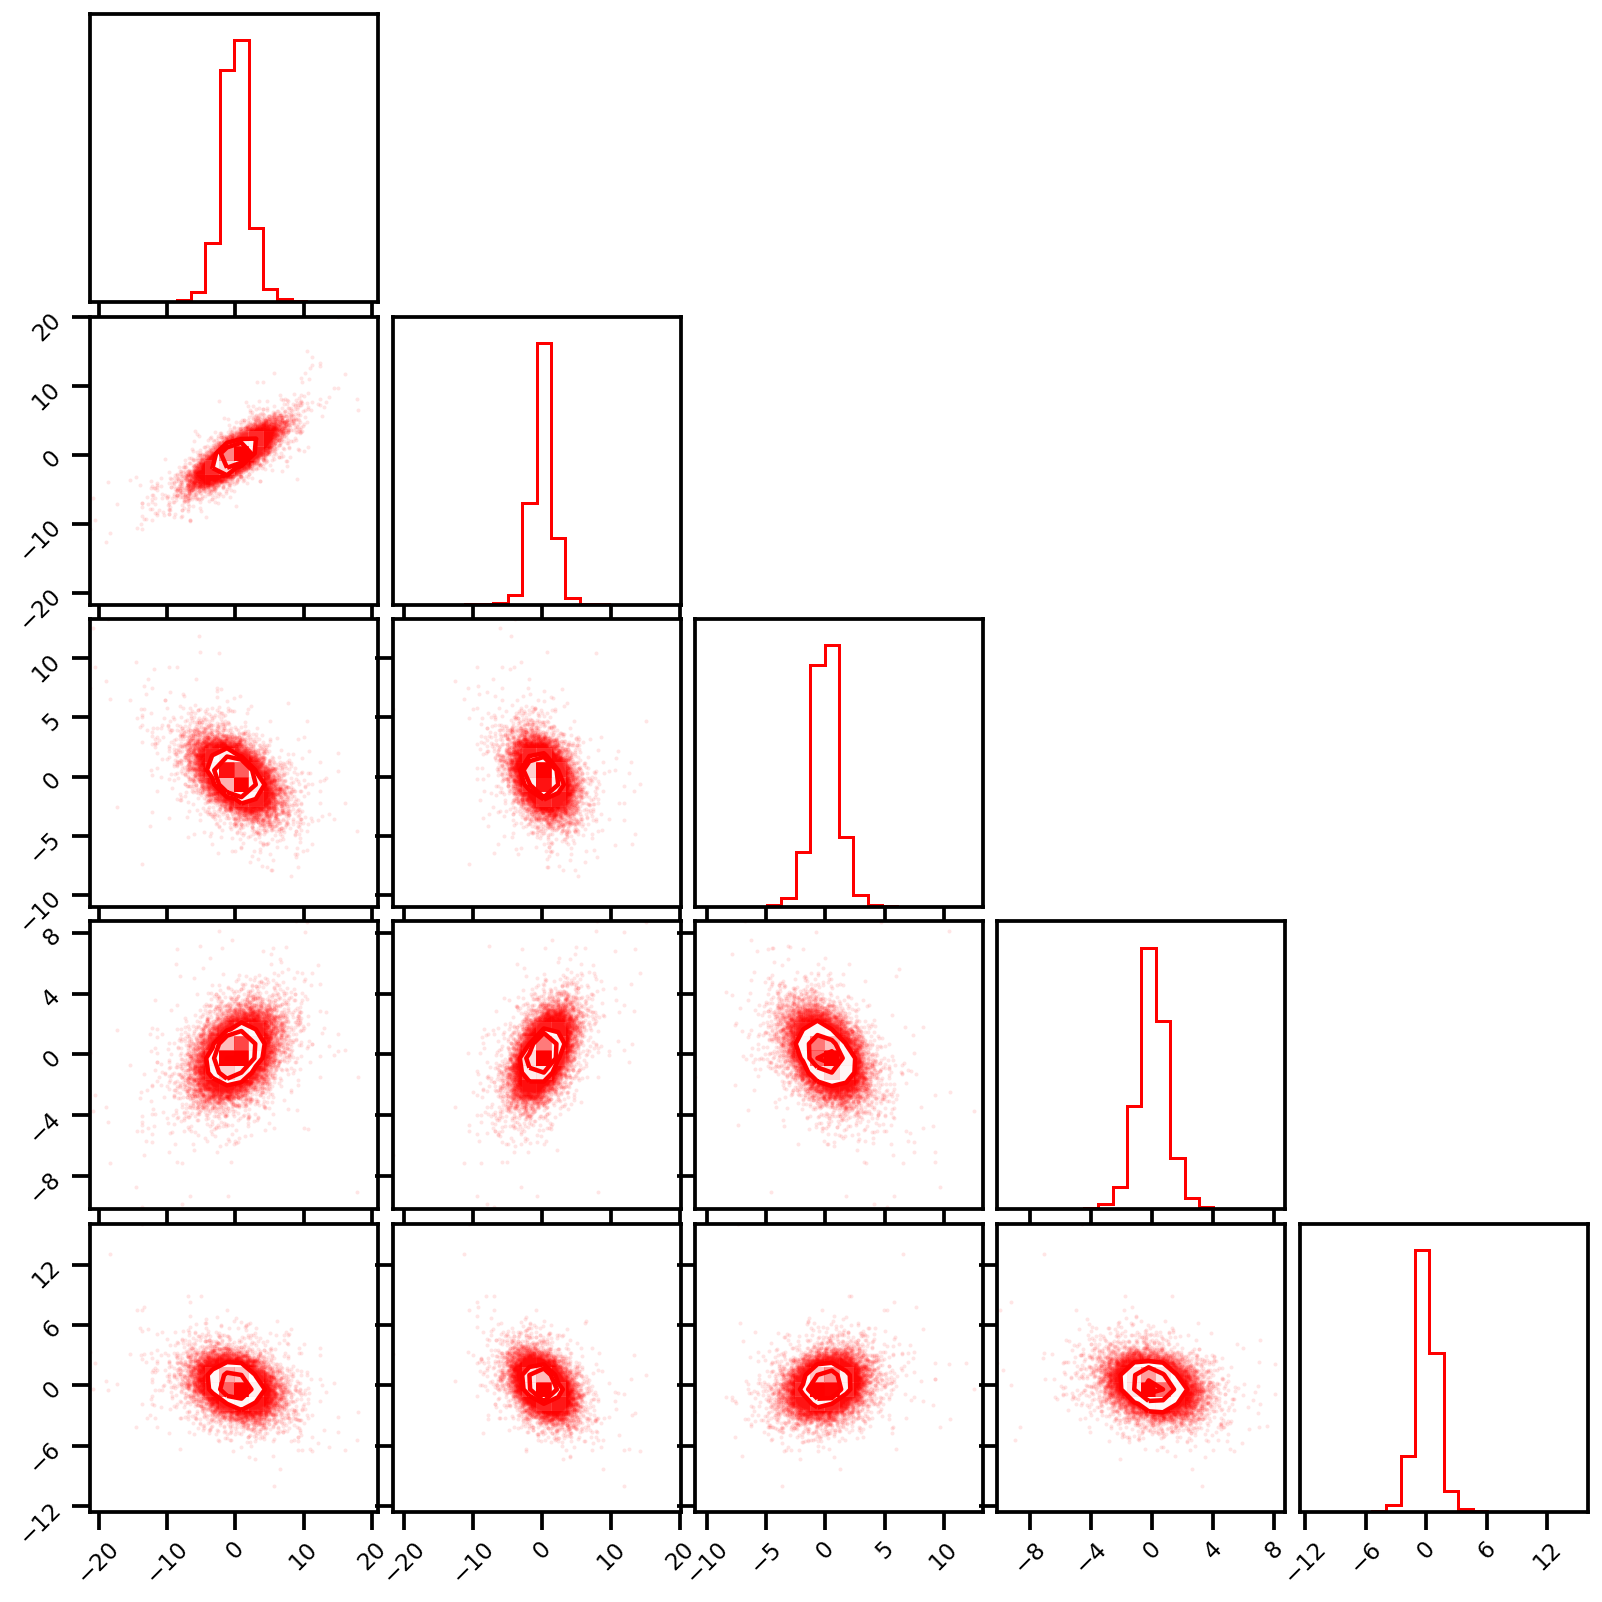

In [25]:
fig = corner.corner(res_tuple.X[:, :10], color="blue")
fig = corner.corner(res_tuple.Y[:, :10], color="red")

#### Mutual Information

$$
I(\mathbf{X,Y}) = H(\mathbf{X}) + H(\mathbf{Y}) - H(\mathbf{X,Y})
$$

for which the standard entropy formula has a closed-form solution as found in the paper by [ Guerrero-Cusumano et al (1996)](https://www.sciencedirect.com/science/article/pii/0020025596000448) (eqn 8). 

$$
\begin{aligned}
H(D,\nu, \boldsymbol{\Sigma}) &= \frac{1}{2}\log \left|\boldsymbol{\Sigma} \right| \\
&+ \log \left[ \frac{((\nu-2) \pi)^{\frac{D}{2}}}{\Gamma\left(\frac{D}{2} \right)}  \beta \left( \frac{D}{2},\frac{\nu}{2} \right)\right] \\
&+ \frac{\nu + D}{2} \left[ \psi\left( \frac{\nu + D}{2} \right)-\psi\left( \frac{\nu}{2} \right) \right]
\end{aligned}
$$

**Note**: This is **only** for the case where the degrees of freedom, $\nu$ is greater or equal to 2.

In [26]:
res_tuple.MI

1.5789464496427499

#### Estimators

In [27]:
get_mi_estimators(res_tuple.X.copy(), res_tuple.Y.copy())

Gaussian: 1.4207 | Time: 0.0151 secs
KNN (Neighbours):  1.4615 | Time: 12.8173 secs
KNN (epsilon):  1.3863 | Time: 10.5251 secs


### Cauchy

This is a special case of the T-Student Distribution when the degrees of freedom, $\nu$, is equal to 1. 

In [28]:
# create seed (trial number)
df = 1.0
res_tuple = generate_studentt_mi_data(
    n_samples=n_samples,
    n_features=n_features,
    df=df,
    seed=seed,
    n_base_samples=500_000,
)

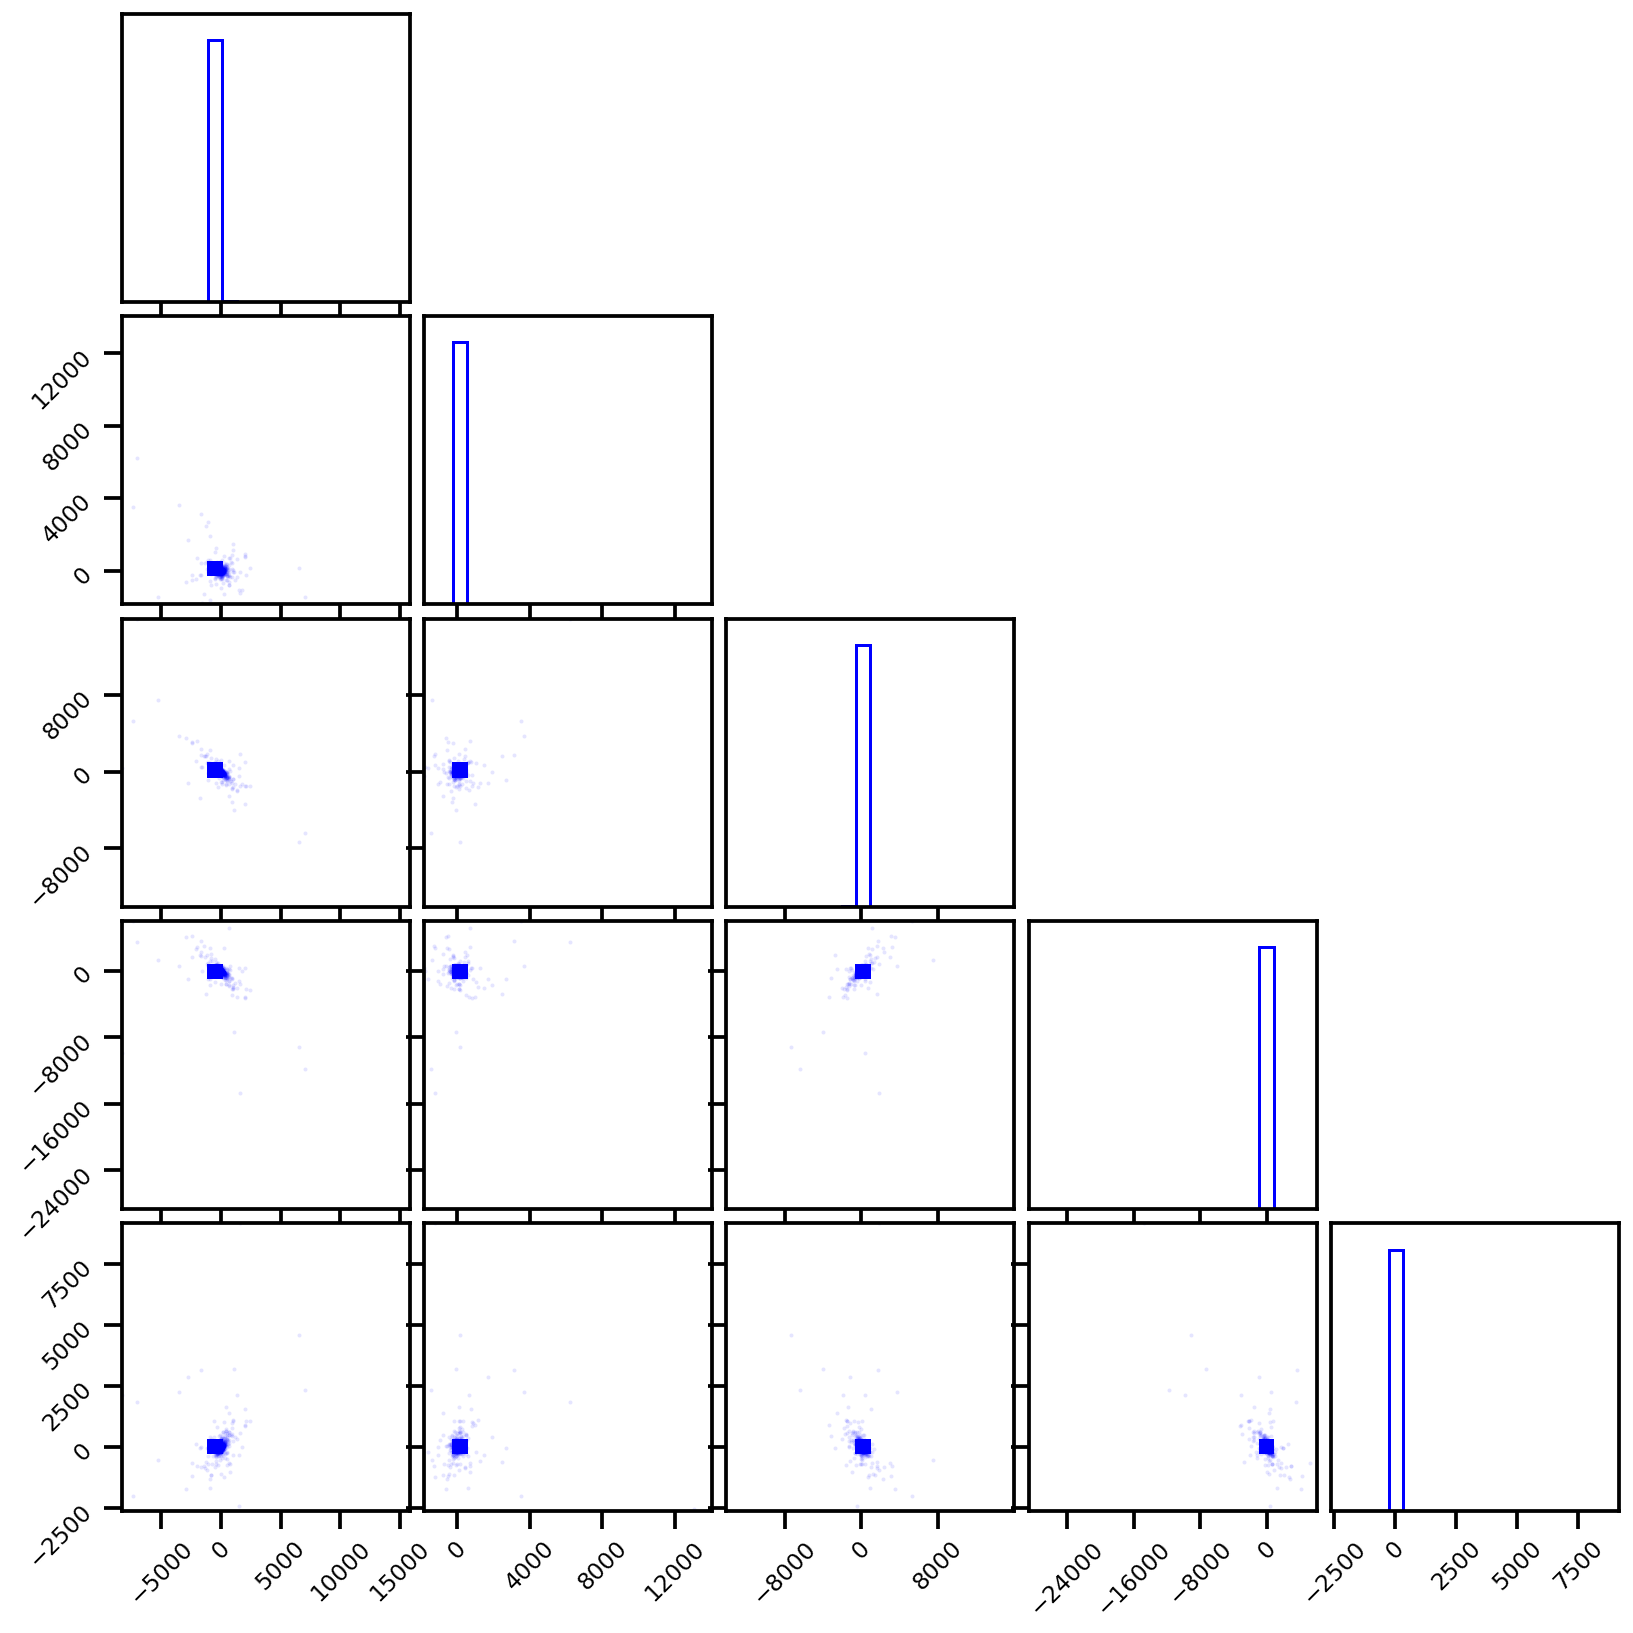

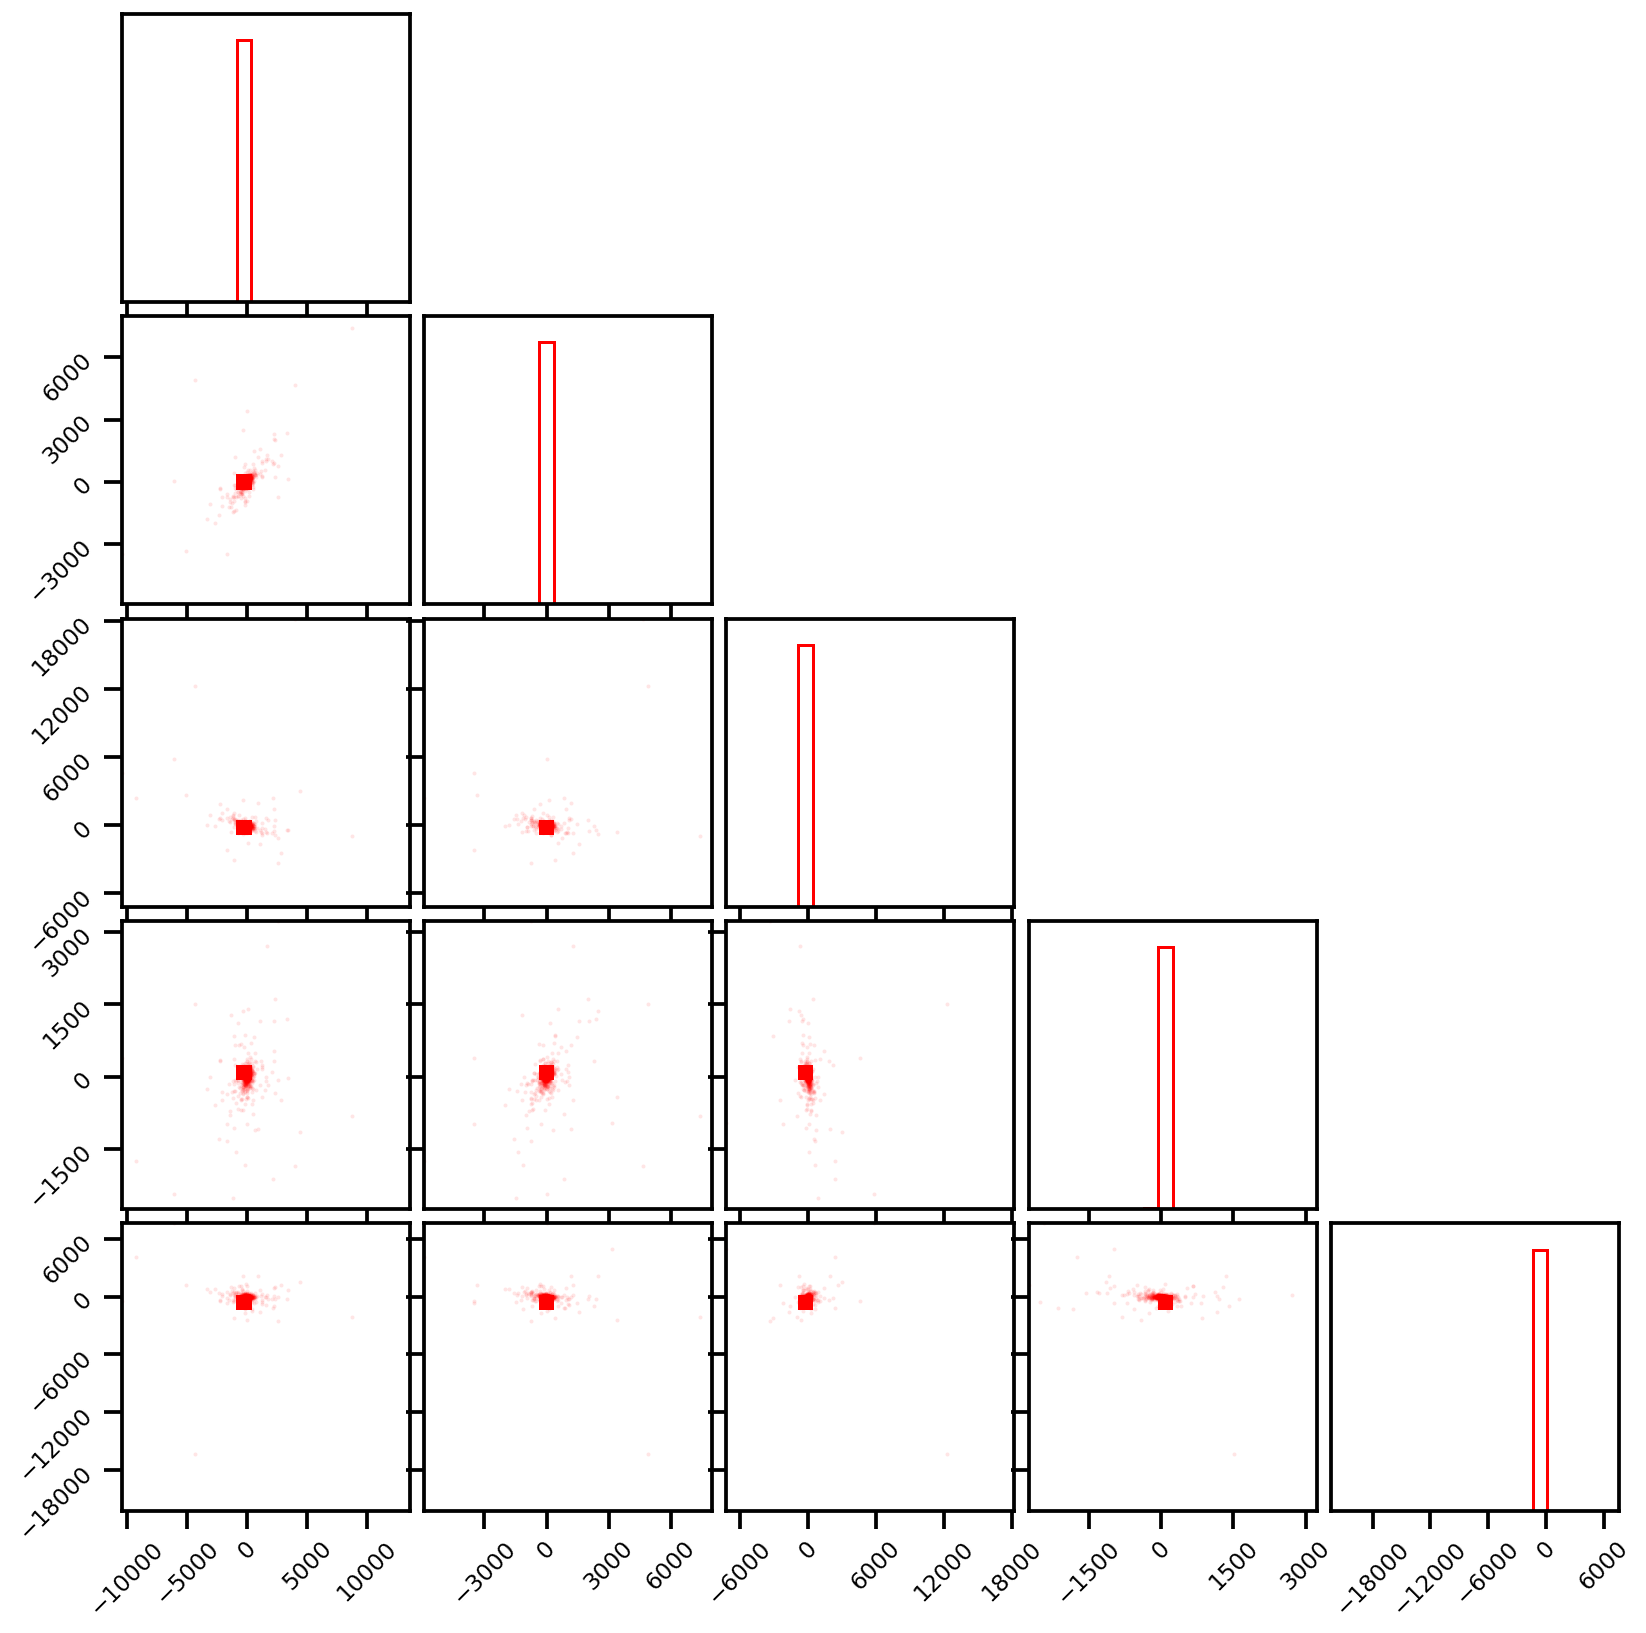

In [29]:
fig = corner.corner(res_tuple.X[:, :10], color="blue")
fig = corner.corner(res_tuple.Y[:, :10], color="red")

#### Mutual Information

$$
I(\mathbf{X,Y}) = H(\mathbf{X}) + H(\mathbf{Y}) - H(\mathbf{X,Y})
$$

Again, this has a closed-form solution as found in the paper by [ Guerrero-Cusumano et al (1996)](https://www.sciencedirect.com/science/article/pii/0020025596000448) (eqn ...). 

$$
\begin{aligned}
H(D,\nu, \boldsymbol{\Sigma}) &= \frac{1}{2}\log \left|\boldsymbol{\Sigma} \right| \\
&+ \log \left[ \frac{(\pi)^{\frac{D}{2}}}{\Gamma\left(\frac{D}{2} \right)}  \beta \left( \frac{D}{2},\frac{1}{2} \right)\right] \\
&+ \frac{1 + D}{2} \left[ \psi\left( \frac{1 + D}{2} \right)-\psi\left( \frac{1}{2} \right) \right]
\end{aligned}
$$

**Note**: This is **only** for the case where the degrees of freedom, $\nu$ is greater or equal to 2.

In [30]:
res_tuple.MI

2.2147363080731566

#### Estimators

In [31]:
get_mi_estimators(res_tuple.X.copy(), res_tuple.Y.copy())

Gaussian: 2.4588 | Time: 0.0149 secs
KNN (Neighbours):  2.1319 | Time: 12.7217 secs
KNN (epsilon):  1.7706 | Time: 10.1697 secs
